# t-Distributed Stochastic Neighbor Embedding (t-SNE)

Este notebook explora o t-SNE, uma técnica de redução de dimensionalidade não linear particularmente eficaz para a visualização de datasets de alta dimensão. Diferentemente de métodos como o PCA, que se concentram em preservar a variância global, o t-SNE foca em preservar a estrutura local, ou seja, as similaridades entre pontos vizinhos. Ele modela as similaridades entre pontos de dados tanto no espaço de alta dimensão quanto no de baixa dimensão e busca minimizar a divergência entre essas duas distribuições de similaridade.

## Fundamentação

O t-SNE opera em duas etapas principais: primeiro, ele constrói uma distribuição de probabilidade sobre pares de pontos de dados de alta dimensão, de modo que pontos similares tenham uma alta probabilidade de serem escolhidos, enquanto pontos dissimilares tenham uma probabilidade extremamente baixa. Segundo, ele define uma distribuição de probabilidade similar sobre os pontos no mapa de baixa dimensão e minimiza a divergência de Kullback-Leibler (KL) entre as duas distribuições em relação às localizações dos pontos no mapa.

### Similaridades no Espaço de Alta Dimensão

A similaridade entre os pontos de dados $x_i$ e $x_j$ é a probabilidade condicional, $p_{j|i}$, de que $x_i$ escolheria $x_j$ como seu vizinho se os vizinhos fossem escolhidos em proporção à sua densidade de probabilidade sob uma Gaussiana centrada em $x_i$. A probabilidade é dada por:

$$
p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
$$

A variância da Gaussiana, $\sigma_i^2$, é determinada para cada ponto de dados individualmente através de uma busca binária. Essa busca é realizada para encontrar um $\sigma_i$ que produza uma distribuição de probabilidade $P_i$ com uma perplexidade específica, um hiperparâmetro definido pelo usuário. A perplexidade pode ser interpretada como uma medida suave do número efetivo de vizinhos para cada ponto.

Para obter uma distribuição de probabilidade conjunta, o t-SNE simetriza essas probabilidades condicionais:

$$
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}
$$

onde $n$ é o número de pontos de dados.

### Similaridades no Espaço de Baixa Dimensão

No espaço de baixa dimensão (geralmente 2D ou 3D), o t-SNE utiliza uma distribuição t de Student com um grau de liberdade (que é equivalente a uma distribuição de Cauchy) para medir as similaridades entre os pontos de baixa dimensão $y_i$ e $y_j$. O uso de uma distribuição de cauda longa como a t de Student permite que pontos moderadamente distantes no espaço de alta dimensão sejam mapeados para distâncias maiores no espaço de baixa dimensão, ajudando a aliviar o problema de "crowding" (aglomeração). A probabilidade conjunta $q_{ij}$ é definida como:

$$
q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
$$

### Otimização via Minimização da Divergência KL

O objetivo do t-SNE é fazer com que a distribuição $Q$ (no espaço de baixa dimensão) reflita a distribuição $P$ (no espaço de alta dimensão) da melhor forma possível. Isso é alcançado minimizando a divergência de Kullback-Leibler entre as duas distribuições:

$$
C = \text{KL}(P||Q) = \sum_{i} \sum_{j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

A minimização desta função de custo é realizada usando o método do gradiente descendente. O gradiente da divergência KL em relação aos pontos no embedding $y_i$ possui uma forma surpreendentemente simples, que é a diferença entre as forças de atração (puxando pontos similares para perto) e as forças de repulsão (empurrando pontos dissimilares para longe).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import seaborn as sns

### Gerando um Dataset Sintético

Para demonstrar o t-SNE, vamos primeiro gerar um conjunto de dados sintético com clusters bem definidos. Usaremos a função `make_blobs` da biblioteca `scikit-learn`.

In [ ]:
n_samples = 300
n_features = 20
n_clusters = 5

X, y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=42,
    cluster_std=5.0
)

print("Formato do dataset X:", X.shape)
print("Formato do vetor y:", y.shape)

Formato do dataset X: (300, 20)
Formato do vetor y: (300,)


KeyboardInterrupt: 

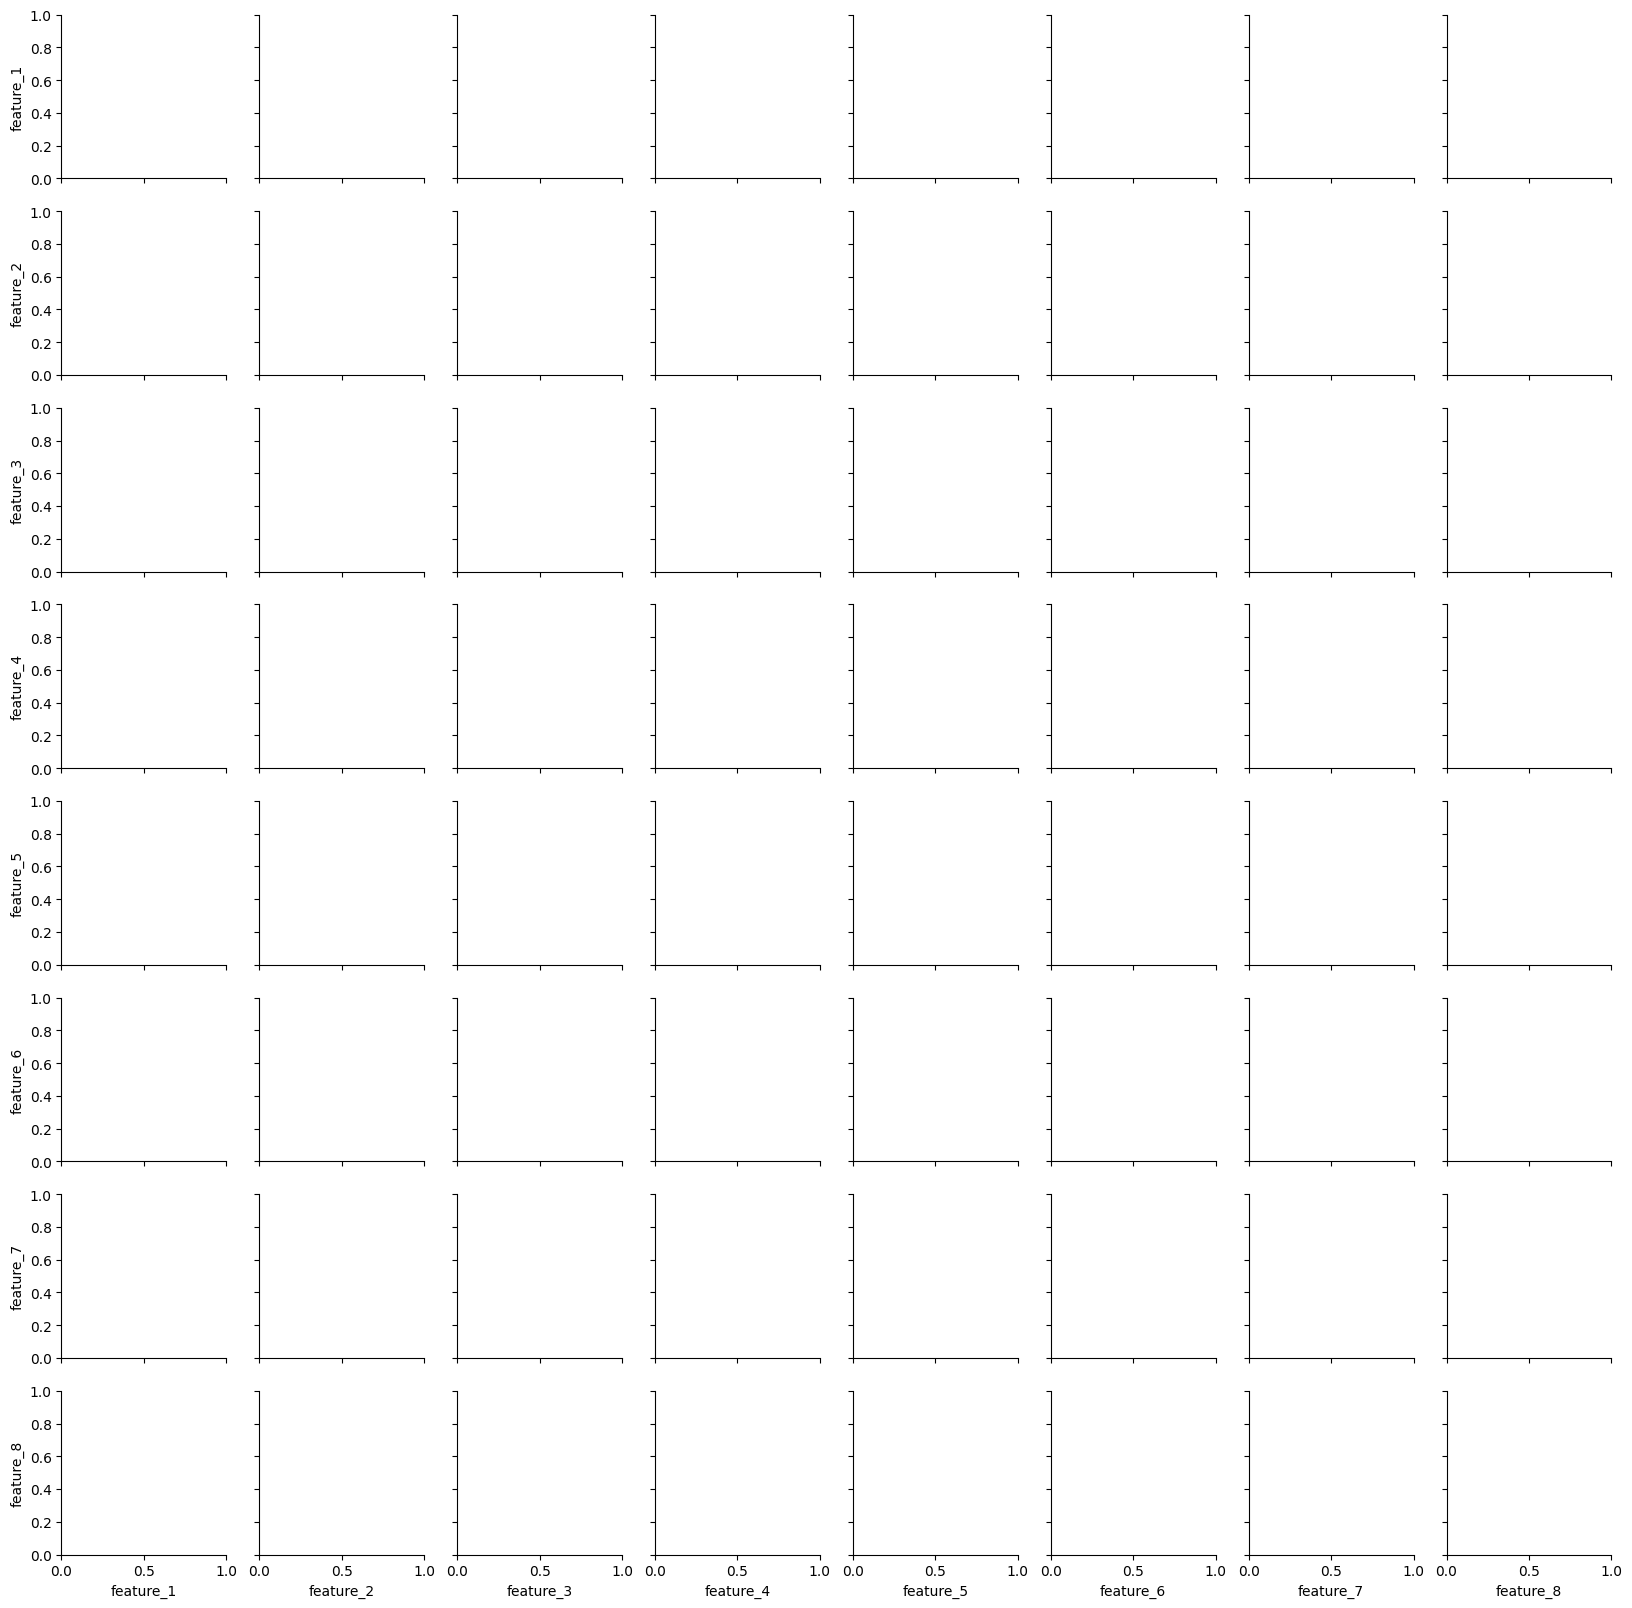

In [ ]:
df = pd.DataFrame(X[:, :8], columns=[f'feature_{i+1}' for i in range(8)])
df['cluster'] = y

sns.pairplot(df, hue='cluster', palette='hls')
plt.suptitle("Pairplot das primeiras features (sem t-SNE)", y=1.02)
plt.show()

## Implementação da Classe t-SNE

Agora, vamos implementar o algoritmo t-SNE, encapsulando a lógica em uma classe Python com uma interface similar à do `scikit-learn`. Esta implementação se concentrará na clareza do algoritmo, em vez de otimizações de performance.

In [ ]:
class TSNE:
    def __init__(self, n_components=2, perplexity=30.0, lr=200.0, n_iter=500):
        # Número de dimensões finais, perplexidade, taxa de aprendizado e iterações
        self.n_components = n_components
        self.perplexity = perplexity
        self.lr = lr
        self.n_iter = n_iter

    # -------------------------------------------------------
    # 1. Calcula matriz de distâncias euclidianas ao quadrado
    # -------------------------------------------------------
    def _distances(self, X):
        sum_X = np.sum(X**2, axis=1)
        return np.add(np.add(-2 * X @ X.T, sum_X).T, sum_X)

    # -------------------------------------------------------------------------
    # 2. Calcula a matriz P (probabilidades no espaço de alta dimensão)
    #    Cada linha P[i] é ajustada para ter uma entropia que corresponda à perplexidade
    # -------------------------------------------------------------------------
    def _p_matrix(self, D):
        n = D.shape[0]
        P = np.zeros((n, n))
        logU = np.log2(self.perplexity)

        for i in range(n):
            beta = 1.0  # inverso da variância (1 / (2*sigma²))
            Di = np.delete(D[i], i)  # remove a distância com ele mesmo

            # Ajuste de beta por busca simples até alcançar a perplexidade desejada
            for _ in range(30):
                P_i = np.exp(-Di * beta)
                P_i /= np.sum(P_i)
                H = -np.sum(P_i * np.log2(P_i + 1e-12))  # entropia
                if abs(H - logU) < 1e-3:  # se já está próximo, para
                    break
                beta *= 1.2 if H > logU else 0.8  # ajusta beta

            P[i, np.arange(n) != i] = P_i

        # Simetriza e normaliza
        P = (P + P.T) / (2 * n)
        return np.maximum(P, 1e-12)

    # -------------------------------------------------------
    # 3. Executa o t-SNE e retorna o embedding 2D
    # -------------------------------------------------------
    def fit_transform(self, X):
        n = X.shape[0]

        # Calcula afinidades no espaço original (P)
        D = self._distances(X)
        P = self._p_matrix(D)

        # Inicializa o embedding aleatoriamente
        Y = np.random.randn(n, self.n_components)

        # Loop de otimização
        for it in range(self.n_iter):
            # Calcula afinidades no espaço de baixa dimensão (Q)
            sum_Y = np.sum(Y**2, axis=1)
            num = 1 / (1 + np.add(np.add(-2 * Y @ Y.T, sum_Y).T, sum_Y))
            np.fill_diagonal(num, 0)
            Q = np.maximum(num / np.sum(num), 1e-12)

            # Calcula o gradiente
            PQ = P - Q
            for i in range(n):
                # Soma ponderada das diferenças (força de atração/repulsão)
                dY_i = np.sum((PQ[:, i] * num[:, i])[:, None] * (Y[i] - Y), axis=0)
                Y[i] -= self.lr * dY_i  # Atualiza posição

            # Centraliza os pontos
            Y -= np.mean(Y, axis=0)

            # Mostra custo a cada 100 iterações
            if (it + 1) % 100 == 0:
                cost = np.sum(P * np.log(P / Q))
                print(f"Iter {it+1:4d}: cost = {cost:.4f}")

        return Y

### Aplicando

Vamos agora instanciar nossa classe `TSNE` e aplicá-la ao mesmo dataset sintético. O processo de otimização será impresso, mostrando o valor da função de custo em intervalos regulares.

In [ ]:
custom_tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, lr=200)
X_embedded_custom = custom_tsne.fit_transform(X)

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.7893
Iter  200: cost = 0.6557
Iter  300: cost = 0.6202
Iter  400: cost = 0.6003
Iter  500: cost = 0.5876
Iter  600: cost = 0.5784
Iter  700: cost = 0.5711
Iter  800: cost = 0.5610
Iter  900: cost = 0.5519
Iter 1000: cost = 0.5481


### Visualizando o Resultado da Implementação

Finalmente, plotamos o resultado gerado pela nossa implementação.

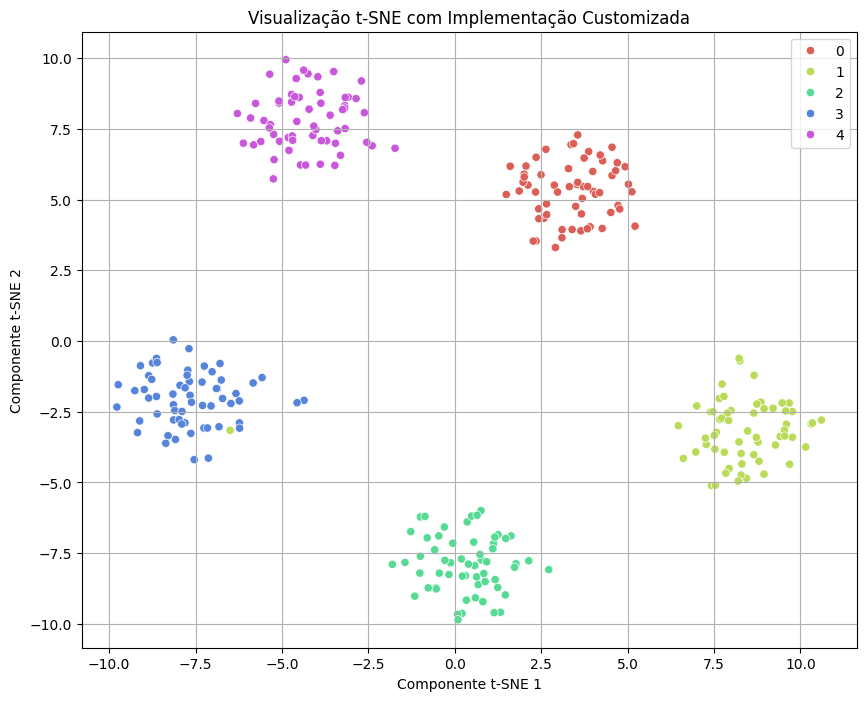

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_embedded_custom[:, 0],
    y=X_embedded_custom[:, 1],
    hue=y,
    palette=sns.color_palette("hls", n_clusters),
    legend="full"
)
plt.title('Visualização t-SNE com Implementação Customizada')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.grid(True)
plt.show()

## Exercícios

### Exercício 1

Treine diferentes modelos t-SNE em 2D com diferentes valores de perplexidade para o dataset sintético e plote cada um deles.

In [ ]:
custom_tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, lr=200)
X_embedded_custom = custom_tsne.fit_transform(X)


perplexity=5.0, iter=1


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 1.9926
Iter  200: cost = 1.6741
Iter  300: cost = 1.5397
Iter  400: cost = 1.4603
Iter  500: cost = 1.4062
Iter  600: cost = 1.3633
Iter  700: cost = 1.3273
Iter  800: cost = 1.2958
Iter  900: cost = 1.2675
Iter 1000: cost = 1.2431

perplexity=10.0, iter=2


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 1.5621
Iter  200: cost = 1.3352
Iter  300: cost = 1.2357
Iter  400: cost = 1.1758
Iter  500: cost = 1.1299
Iter  600: cost = 1.0975
Iter  700: cost = 1.0698
Iter  800: cost = 1.0500
Iter  900: cost = 1.0351
Iter 1000: cost = 1.0199

perplexity=15.0, iter=3


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 1.1954
Iter  200: cost = 1.0336
Iter  300: cost = 0.9650
Iter  400: cost = 0.9211
Iter  500: cost = 0.8925
Iter  600: cost = 0.8687
Iter  700: cost = 0.8518
Iter  800: cost = 0.8372
Iter  900: cost = 0.8251
Iter 1000: cost = 0.8155

perplexity=20.0, iter=4


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 1.0800
Iter  200: cost = 0.9395
Iter  300: cost = 0.8641
Iter  400: cost = 0.8123
Iter  500: cost = 0.7728
Iter  600: cost = 0.7572
Iter  700: cost = 0.7452
Iter  800: cost = 0.7351
Iter  900: cost = 0.7267
Iter 1000: cost = 0.7189

perplexity=25.0, iter=5


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.8801
Iter  200: cost = 0.7486
Iter  300: cost = 0.6995
Iter  400: cost = 0.6674
Iter  500: cost = 0.6499
Iter  600: cost = 0.6380
Iter  700: cost = 0.6292
Iter  800: cost = 0.6223
Iter  900: cost = 0.6167
Iter 1000: cost = 0.6120

perplexity=30.0, iter=6


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.7590
Iter  200: cost = 0.6671
Iter  300: cost = 0.6178
Iter  400: cost = 0.5914
Iter  500: cost = 0.5667
Iter  600: cost = 0.5560
Iter  700: cost = 0.5487
Iter  800: cost = 0.5430
Iter  900: cost = 0.5384
Iter 1000: cost = 0.5346

perplexity=35.0, iter=7


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.6834
Iter  200: cost = 0.5913
Iter  300: cost = 0.5607
Iter  400: cost = 0.5421
Iter  500: cost = 0.5246
Iter  600: cost = 0.5158
Iter  700: cost = 0.5101
Iter  800: cost = 0.5056
Iter  900: cost = 0.5019
Iter 1000: cost = 0.4987

perplexity=40.0, iter=8


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.5713
Iter  200: cost = 0.4875
Iter  300: cost = 0.4604
Iter  400: cost = 0.4454
Iter  500: cost = 0.4363
Iter  600: cost = 0.4301
Iter  700: cost = 0.4254
Iter  800: cost = 0.4217
Iter  900: cost = 0.4189
Iter 1000: cost = 0.4165

perplexity=45.0, iter=9


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.5179
Iter  200: cost = 0.4478
Iter  300: cost = 0.4214
Iter  400: cost = 0.4075
Iter  500: cost = 0.3998
Iter  600: cost = 0.3942
Iter  700: cost = 0.3897
Iter  800: cost = 0.3859
Iter  900: cost = 0.3816
Iter 1000: cost = 0.3742

perplexity=50.0, iter=10


/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.4698
Iter  200: cost = 0.4097
Iter  300: cost = 0.3843
Iter  400: cost = 0.3682
Iter  500: cost = 0.3623
Iter  600: cost = 0.3587
Iter  700: cost = 0.3561
Iter  800: cost = 0.3541
Iter  900: cost = 0.3516
Iter 1000: cost = 0.3502


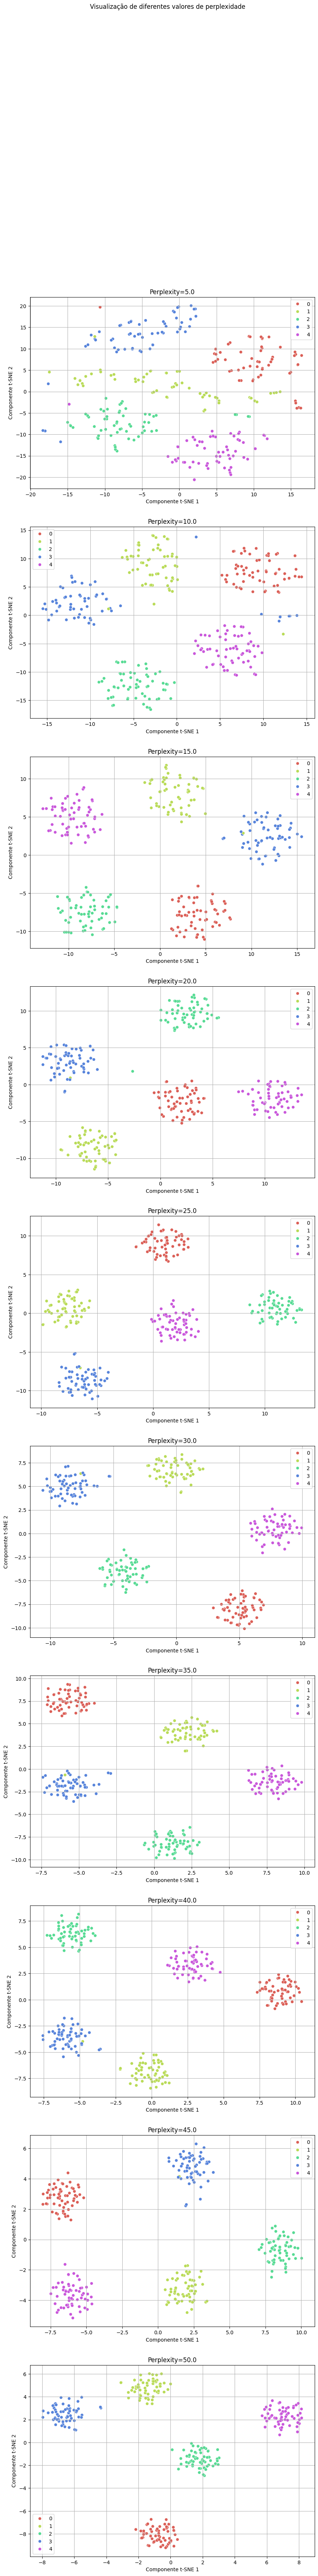

In [ ]:
perplexity_values = np.linspace(5, 50, 10)
len_perplexity = len(perplexity_values)

fig, ax = plt.subplots(len_perplexity, 1, figsize=(10, 8 * len_perplexity))

for i, perplexity in enumerate(perplexity_values):
    print(f'\nperplexity={perplexity}, iter={i+1}')
    custom_tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=1000,
        lr=200
    )
    X_embedded_custom = custom_tsne.fit_transform(X)

    ax[i] = sns.scatterplot(
        x=X_embedded_custom[:, 0],
        y=X_embedded_custom[:, 1],
        hue=y,
        palette=sns.color_palette("hls", n_clusters),
        legend="full",
        ax=ax[i]
    )
    ax[i].set_title(f'Perplexity={perplexity}')
    ax[i].set_xlabel('Componente t-SNE 1')
    ax[i].set_ylabel('Componente t-SNE 2')
    ax[i].grid(True)

plt.suptitle('Visualização de diferentes valores de perplexidade')
plt.show()

### Exercício 2

Faça um treinamento de um modelo t-SNE para o Dataset Wine. Em seguida, plote o resultado em duas dimensões.

In [ ]:
from sklearn.datasets import load_wine

In [ ]:
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.6624
Iter  200: cost = 0.5493
Iter  300: cost = 0.4827
Iter  400: cost = 0.4494
Iter  500: cost = 0.4182
Iter  600: cost = 0.3976
Iter  700: cost = 0.3841
Iter  800: cost = 0.3744
Iter  900: cost = 0.3668
Iter 1000: cost = 0.3604


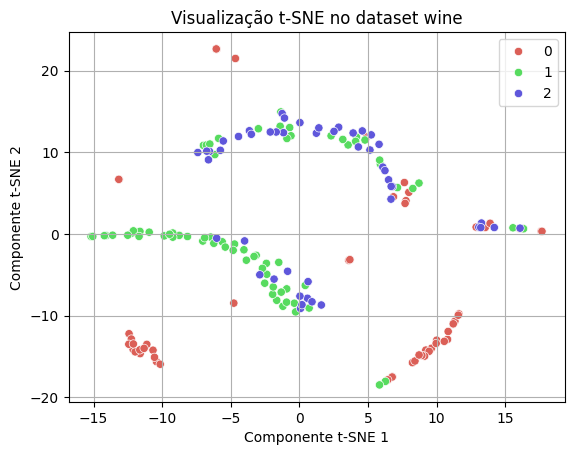

In [ ]:
wine_custom_tsne = TSNE(
    n_components=2,
    perplexity=7,
    n_iter=400,
    lr=100
)
X_embedded_wine = custom_tsne.fit_transform(X_wine)

sns.scatterplot(
    x=X_embedded_wine[:, 0],
    y=X_embedded_wine[:, 1],
    hue=y_wine,
    palette=sns.color_palette("hls", 3),
    legend="full",
)
plt.title('Visualização t-SNE no dataset wine')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.grid(True)
plt.show()